<a href="https://colab.research.google.com/github/eitanfass/image-processing/blob/main/trained_model_for_final_project_tomato_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# importing os module


Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [3]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
!dpkg -i libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
!ls -l /usr/lib/x86_64-linux-gnu/libcudnn.so.*
!pip install -U -qq tensorflow==2.5.0
exit() # Runtime restart required!

--2023-01-06 12:53:51--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.39.144
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 430460776 (411M) [application/x-deb]
Saving to: ‘libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb’

libcudnn8_8.1.0.77- 100%[===================>] 410.52M  39.5MB/s    in 10s     

2023-01-06 12:54:01 (40.0 MB/s) - ‘libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb’ saved [430460776/430460776]

dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 to 8.1.0.77-1+cuda11.2
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+cuda11.2) over (8.1.1.33-1+cuda11.2) ...
Setting up libcudnn8 (8.1.0.77-1+

In [1]:
# Notice how the TF version is now 2.5.0
import tensorflow as tf
tf.__version__

'2.5.0'

In [2]:
# let's make sure we have a GPU, under device_type
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1919559249364261269, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14474280960
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4453677875903903084
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [3]:
# our GPU card is probably Tesla T4 (what we get from Google)
!nvidia-smi

Fri Jan  6 12:58:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |    256MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# batch rename files script
# use it, if you downloaded a lot of images from google, and you want to rename them from img0 to img100 for example

# Python 3 code to rename multiple
# files in a directory or folder


import os
# Function to rename multiple files
def main():

  test_img_path='/content/drive/MyDrive/71254_2023/02_Assignment_Submission/Eitan.Fass/final project/dataset/test'
  for count, filename in enumerate(os.listdir(test_img_path)):
    dst = f"image{str(count)}.jpg"
    src =f"{test_img_path}/{filename}" # foldername/filename, if .py file is outside folder
    dst =f"{test_img_path}/{dst}"
    
    # rename() function will
    # rename all the files
    os.rename(src, dst)

# Driver Code
if __name__ == '__main__':
	
	# Calling main() function
	main()

In [5]:
!git clone https://github.com/kairess/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 1543, done.
remote: Counting objects: 100% (565/565), done.
remote: Compressing objects: 100% (552/552), done.
remote: Total 1543 (delta 20), reused 554 (delta 13), pack-reused 978
Receiving objects: 100% (1543/1543), 1.26 GiB | 15.56 MiB/s, done.
Resolving deltas: 100% (590/590), done.
Checking out files: 100% (624/624), done.


In [6]:
# import libs
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import torch
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")
ROOT_DIR = 'Mask_RCNN'

sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Training on device cuda.


In [7]:
# Download the pretrained model
# This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [8]:
class TrainConfig(Config):
    # Give the configuration a recognizable name
    NAME = "custom"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5

    LEARNING_RATE = 0.001

    # Number of classes (including background) - IMPORTANT TO CHANGE ACCORDING TO YOUR LABELS IN YOUR JSON
    NUM_CLASSES = 1 + 6  # background + 1 (6 class)

    # All of our training images are 1920x1012
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50' # resnet50

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 60 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [9]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

Train 643
test 161


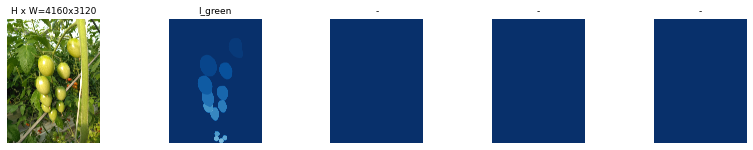

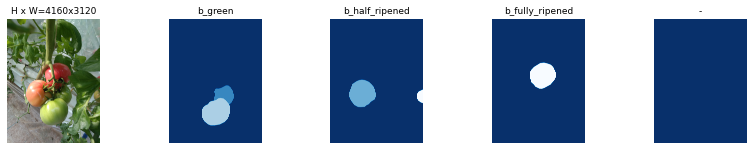

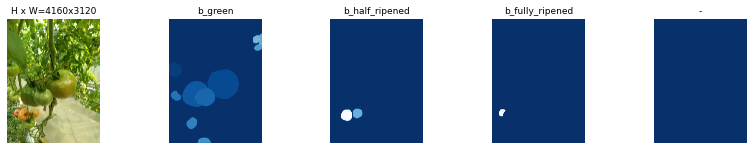

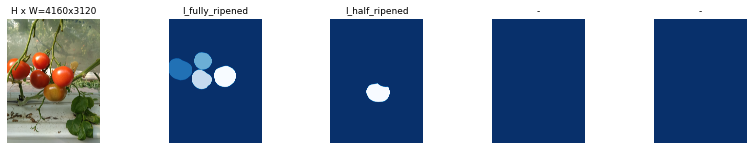

In [10]:
root_folder = r'/content/drive/MyDrive/71254_2023/02_Assignment_Submission/Eitan.Fass/final project'

dataset_train = CocoLikeDataset()
dataset_train.load_data(f'{root_folder}/dataset/train.json', f'{root_folder}/dataset/train/')
dataset_train.prepare()

dataset_test = CocoLikeDataset()
dataset_test.load_data(f'{root_folder}/dataset/test.json', f'{root_folder}/dataset/test/')
dataset_test.prepare()

image_ids = np.random.choice(dataset_train.image_ids, 4)

print('Train', len(dataset_train.image_ids))
print('test', len(dataset_test.image_ids))

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [11]:
model = modellib.MaskRCNN(
    mode="training",
    config=config,
    model_dir=MODEL_DIR)

model.load_weights(
    COCO_MODEL_PATH,
    by_name=True,
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()

model.train(
    dataset_train,
    dataset_train, 
    learning_rate=config.LEARNING_RATE, 
    epochs=10, 
    layers='heads')

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)

print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: Mask_RCNN/logs/custom20230106T1301/mask_rcnn_custom_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistr

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_5:0", shape=(Non

129/129 [==============================] - ETA: 0s - batch: 64.0000 - size: 5.0000 - loss: 2.1733 - rpn_class_loss: 0.1919 - rpn_bbox_loss: 0.5241 - mrcnn_class_loss: 0.6930 - mrcnn_bbox_loss: 0.4023 - mrcnn_mask_loss: 0.3619 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


129/129 [==============================] - 2502s 19s/step - batch: 64.0000 - size: 5.0000 - loss: 2.1733 - rpn_class_loss: 0.1919 - rpn_bbox_loss: 0.5241 - mrcnn_class_loss: 0.6930 - mrcnn_bbox_loss: 0.4023 - mrcnn_mask_loss: 0.3619 - val_loss: 1.6036 - val_rpn_class_loss: 0.1302 - val_rpn_bbox_loss: 0.4090 - val_mrcnn_class_loss: 0.5292 - val_mrcnn_bbox_loss: 0.2733 - val_mrcnn_mask_loss: 0.2619
Epoch 2/10
129/129 [==============================] - 2117s 16s/step - batch: 64.0000 - size: 5.0000 - loss: 1.5849 - rpn_class_loss: 0.1323 - rpn_bbox_loss: 0.4363 - mrcnn_class_loss: 0.4983 - mrcnn_bbox_loss: 0.2542 - mrcnn_mask_loss: 0.2637 - val_loss: 1.5175 - val_rpn_class_loss: 0.1309 - val_rpn_bbox_loss: 0.4377 - val_mrcnn_class_loss: 0.4517 - val_mrcnn_bbox_loss: 0.2325 - val_mrcnn_mask_loss: 0.2647
Epoch 3/10
129/129 [==============================] - 2041s 16s/step - batch: 64.0000 - size: 5.0000 - loss: 1.4091 - rpn_class_loss: 0.1249 - rpn_bbox_loss: 0.3698 - mrcnn_class_loss: 0.43

In [ ]:
 
import shutil

original = r'/content/Mask_RCNN/logs/custom20221228T1436/mask_rcnn_custom_0030.h5'
target = r'/content/drive/MyDrive/71254_2023/02_Assignment_Submission/Eitan.Fass/final project/saved models/mask_rcnn_trained_model_tomatoes.h5'

shutil.copyfile(original, target)

In [ ]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.65 # CHANGE HERE IF YOU WANT

inference_config = InferenceConfig()

# Recreate the model in inference mode
test_model = modellib.MaskRCNN(
    mode="inference", 
    config=inference_config,
    model_dir=MODEL_DIR)

model_path = test_model.find_last()
print(model_path)

test_model.load_weights(model_path, by_name=True)

In [ ]:
import skimage

mask_colors = [
    (0., 0., 0.), # Background
    (1., 0., 0.), # Red
    (0., 1., 0.)  # Green
]

real_test_dir = f'{root_folder}/dataset/test'
image_paths = []

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)

    results = test_model.detect([img_arr], verbose=1)
    r = results[0]

    colors = tuple(np.take(mask_colors, r['class_ids'], axis=0))

    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(16, 8),
                                colors=colors)